In [1]:
#!pip install folium
import common
import pandas as pd
import haversine as hs
import numpy as np

In [2]:
# Read list.json to pandas dataframe, or load it from a file

df = common.df_from_list('list.json')
df.to_hdf('df.h5', 'df')

#df = pd.read_hdf('df.h5', 'df')

print("sla is starting point latitude, slo is starting point longitude, ela is ending point latitude, elo is ending point longitude")

df

sla is starting point latitude, slo is starting point longitude, ela is ending point latitude, elo is ending point longitude


,datetime,duration_minutes,sla,slo,ela,elo
0,2023-01-03 12:11:00,9.650000,49.197684,16.640210,49.189396,16.617106
1,2023-01-03 17:57:55,11.550000,49.189396,16.617106,49.201914,16.641787
2,2023-01-04 11:48:46,10.550000,49.201914,16.641787,49.191415,16.619807
3,2023-01-04 17:53:59,12.533333,49.189396,16.617106,49.201914,16.641787
4,2023-01-09 11:49:58,11.033333,49.201914,16.641787,49.191415,16.619807
...,...,...,...,...,...,...
413,2024-05-10 13:41:37,6.900000,49.196597,16.608866,49.191415,16.619807
414,2024-05-10 13:57:30,15.700000,49.191415,16.619807,49.196597,16.608866
415,2024-05-10 16:42:14,13.950000,49.196597,16.608866,49.223585,16.597762
416,2024-05-10 17:49:07,14.000000,49.220446,16.596705,49.196597,16.608866


In [3]:
pd.set_option('display.precision', 2)

# Calulate distance between start and end location

# we use haversine package to calculate the distance between two points
df['distance_km'] = df.apply(lambda x: hs.haversine((x['sla'], x['slo']), (x['ela'], x['elo']), unit=hs.Unit.KILOMETERS), axis=1)

# I measured that travel distance is approximately 1.25 times the aerial distance
df['real_distance_km'] = df.distance_km * 1.25


# Cleanup

# I never drive more than 50 km on nextbike, anything so high is an error
df = df[df.distance_km < 50]
df = df[df.distance_km > 0]

# I never spent more than 2 hours on nextbike
df = df[df.duration_minutes < 120]

df

,datetime,duration_minutes,sla,slo,ela,elo,distance_km,real_distance_km
0,2023-01-03 12:11:00,9.65,49.20,16.64,49.19,16.62,1.92,2.39
1,2023-01-03 17:57:55,11.55,49.19,16.62,49.20,16.64,2.27,2.84
2,2023-01-04 11:48:46,10.55,49.20,16.64,49.19,16.62,1.98,2.47
3,2023-01-04 17:53:59,12.53,49.19,16.62,49.20,16.64,2.27,2.84
4,2023-01-09 11:49:58,11.03,49.20,16.64,49.19,16.62,1.98,2.47
...,...,...,...,...,...,...,...,...
413,2024-05-10 13:41:37,6.90,49.20,16.61,49.19,16.62,0.98,1.23
414,2024-05-10 13:57:30,15.70,49.19,16.62,49.20,16.61,0.98,1.23
415,2024-05-10 16:42:14,13.95,49.20,16.61,49.22,16.60,3.11,3.88
416,2024-05-10 17:49:07,14.00,49.22,16.60,49.20,16.61,2.80,3.49


In [4]:
# Print general stats about my rides


print("Total distance travelled:  %.2f km" % df.real_distance_km.sum())
print("Total time spent: %.2f" % (df.duration_minutes.sum() / 60), "hours")
print("Total trips:", df.shape[0])

Total distance travelled:  1040.91 km
Total time spent: 76.96 hours
Total trips: 409


In [5]:
# Print monthly aggregated stats

month_agg = common.time_agg(df, 'M', "%Y-%m")
month_agg.index.rename('month', inplace=True)
month_agg['duration_hours'] = pd.to_datetime(month_agg.duration_minutes, unit='m').dt.strftime('%H:%M')
month_agg['speed_kmph'] = month_agg.real_distance_km/(month_agg.duration_minutes/60)

month_agg.drop('duration_minutes', axis=1, inplace=True)


month_agg

,real_distance_km,trips,duration_hours,speed_kmph
month,,,,
2023-01,78.54,33,05:53,13.32
2023-02,55.93,32,04:48,11.63
2023-03,69.04,44,05:17,13.04
2023-04,52.82,25,03:50,13.73
2023-05,63.83,29,04:47,13.31
2023-06,12.62,6,00:52,14.38
2023-09,50.36,17,03:39,13.79
2023-10,97.13,33,06:44,14.41
2023-11,119.47,37,08:40,13.78


In [11]:
# Print daily averages

day_agg = common.time_agg(df, 'D', "%Y-%m-%d")
day_agg.index.rename('date', inplace=True)
day_agg['speed_kmph'] = day_agg.real_distance_km / (day_agg.duration_minutes/60)

print("Average distance per day: %.2f km" % day_agg.real_distance_km.mean())
print("Average number of trips per day: %.2f" % day_agg.trips.mean())
print("Average time spent on bike per day: %.2f minutes" % day_agg.duration_minutes.mean())
day_agg


Average distance per day: 4.59 km
Average number of trips per day: 1.80
Average time spent on bike per day: 20.34 minutes


,real_distance_km,duration_minutes,trips,speed_kmph
date,,,,
2023-01-03,5.23,21.20,2,14.81
2023-01-04,5.31,23.08,2,13.80
2023-01-09,5.31,24.05,2,13.25
2023-01-10,4.01,18.05,2,13.33
2023-01-11,5.88,26.72,3,13.21
...,...,...,...,...
2024-04-30,2.91,11.28,1,15.49
2024-05-07,8.86,40.28,4,13.19
2024-05-08,1.78,11.53,1,9.29


In [7]:
import folium
import pandas as pd

tiles = 'https://tiles.stadiamaps.com/tiles/stamen_toner/{z}/{x}/{y}@2x.png?api_key=e014ecc6-b337-46f2-894e-84d0e652821d'
attr = "stamen Toner"
m = folium.Map(tiles = tiles, attr=attr) 
def create_map(points,w=1, o=0.1):
    coordinates = []
    for p in points:
       coordinates.append(p[0])
       coordinates.append(p[1])
    folium.PolyLine(points,color = 'red',  weight=w, opacity=o).add_to(m)
    df = pd.DataFrame(coordinates).rename(columns={0:'Lat', 1:'Lon'})[['Lat', 'Lon']]
    sw = df[['Lat', 'Lon']].min().values.tolist()
    ne = df[['Lat', 'Lon']].max().values.tolist()
    m.fit_bounds([sw, ne])
    return m

In [8]:
# get (start, end) location tuples
lines = [((i.sla, i.slo), (i.ela, i.elo)) for i in df.itertuples()]

# get bezier curves so that we can se 
arclines = [common.interpolate_arc(i[0][0], i[0][1], i[1][0], i[1][1], 30) for i in lines]

In [9]:

mymap = create_map(arclines,1,.4)
mymap

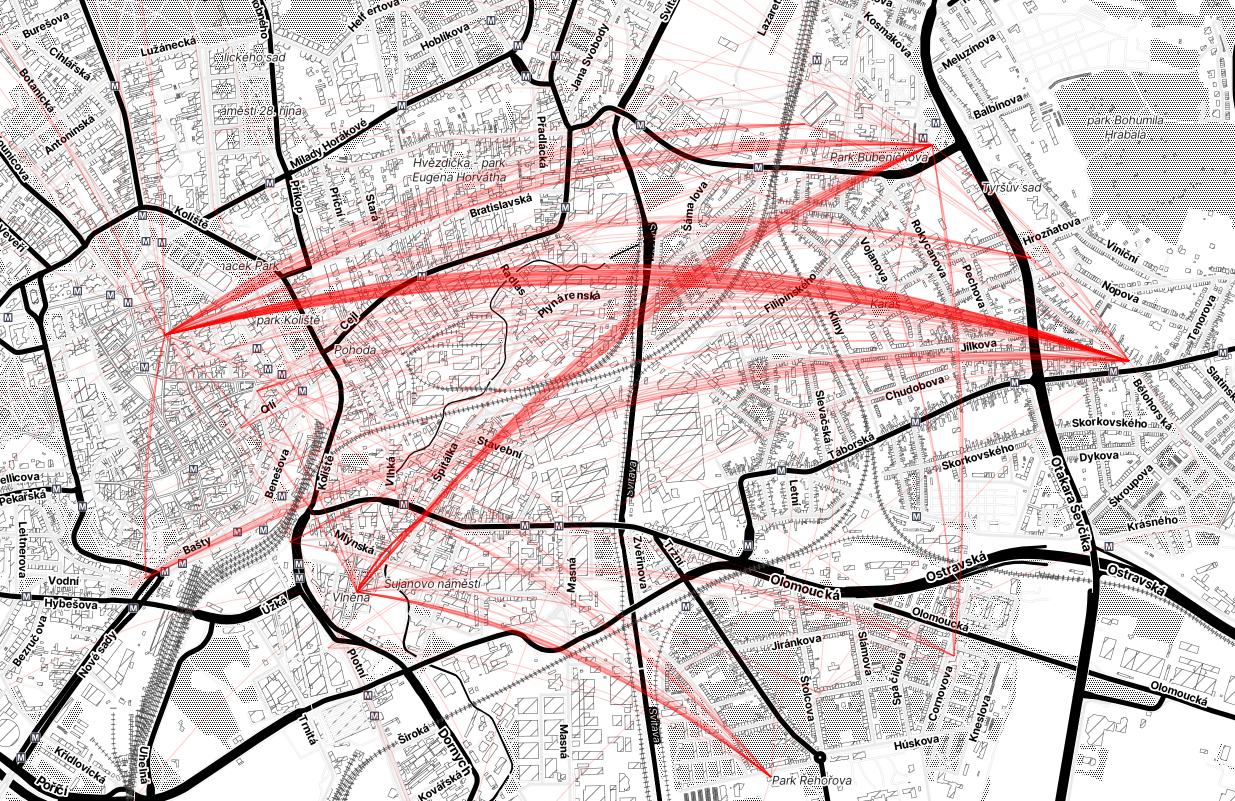

In [10]:
# The map looks more or less like this

from IPython.display import Image
Image(filename='map.png') 